In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import seaborn as sns

import sys
sys.path.append('./python_files/')
import pickle

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## 0) Loading the data (MNIST or CIFAR-10)

In [4]:
train_input_full, train_target_full, test_input_full, test_target_full = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target_full = train_target_full.long()
test_target_full = test_target_full.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [5]:
print("shape of training samples :", train_input_full.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])


In [151]:
nb_sample = 10000
train_input = train_input_full[0:nb_sample]
train_target = train_target_full[0:nb_sample]

test_input = test_input_full[0:nb_sample]
test_target = test_target_full[0:nb_sample]

In [152]:
print("shape of training samples :", train_input.shape)

shape of training samples : torch.Size([10000, 1, 28, 28])


In [153]:
computeClassesWeights(train_target)

tensor([0.1001, 0.1127, 0.0991, 0.1032, 0.0980, 0.0863, 0.1014, 0.1070, 0.0944,
        0.0978])

In [154]:
computeClassesWeights(test_target)

tensor([0.0980, 0.1135, 0.1032, 0.1010, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974,
        0.1009])

## 1) LeNet with disjoint trainset and testset

In [155]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [156]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

In [157]:
model = LeoNet()
load_from_memory = False

In [158]:
#debug_layers_dims(model, train_input.shape)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.62628714           0.796      0.18407753           0.945
100                  0.00012038           1.000      0.08357619           0.982
200                  0.00004928           1.000      0.09076608           0.981
300                  0.00002990           1.000      0.09484406           0.982
400                  0.00002107           1.000      0.09796286           0.981
500                  0.00001611           1.000      0.10021257           0.981
599                  0.00001299           1.000      0.10199530           0.981
*******************************************************************************


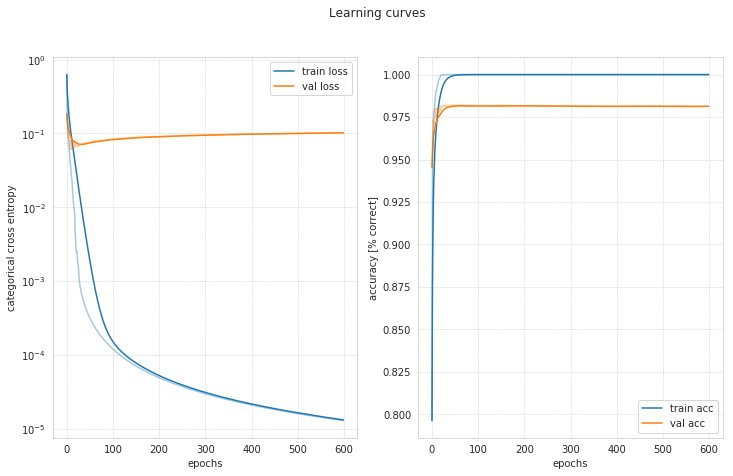

In [159]:
if not load_from_memory:
    
    crit_fun = lambda input_, target : (input_, target)
    y_hat_fun = lambda y: y.argmax(1)
    #batch_cap = 60
    #batch_fun = lambda x, y: x - 2*(y // batch_cap) * batch_cap

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
    learning_rate = 0.1
    mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(train_dataset, test_dataset, epochs=600, batch_size=50, verbose=100)
    mt.plot_training("Learning curves")

training model 0
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    2.32529187           0.123      2.22959304           0.234
100                  0.04295983           0.995      0.22684179           0.930
200                  0.00932175           1.000      0.23627773           0.926
299                  0.00440679           1.000      0.24297276           0.929
*******************************************************************************
training model 1
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    2.29110396           0.102      2.18660831           0.152
100                  0.05683013           0.990      0.33743748           0.903
200                  0.01098352           1.000      0.35384068           0.910
299   

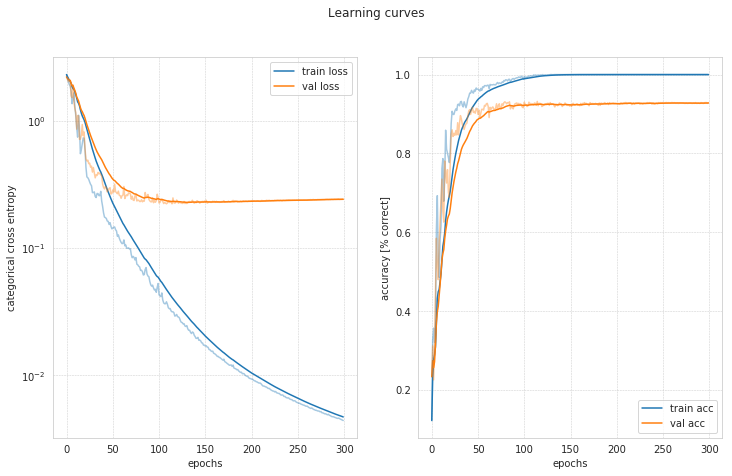

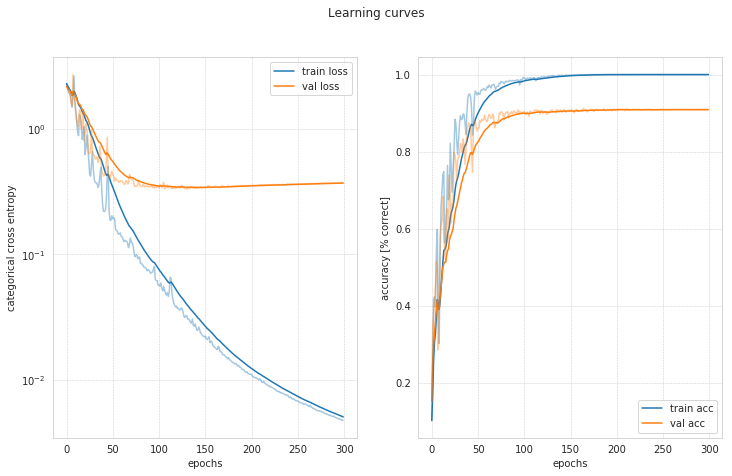

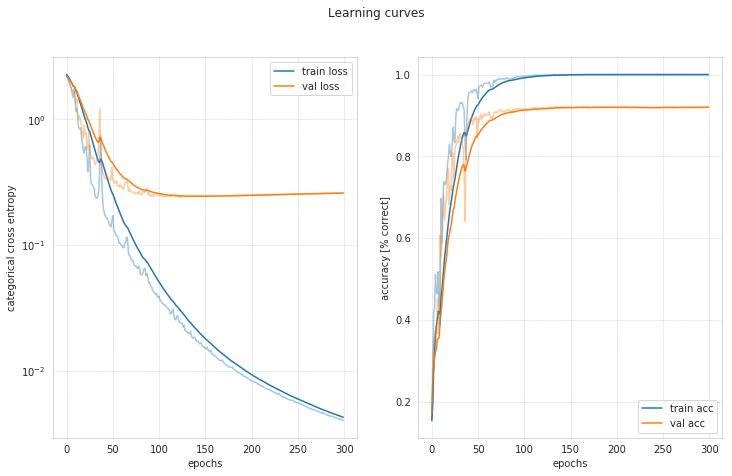

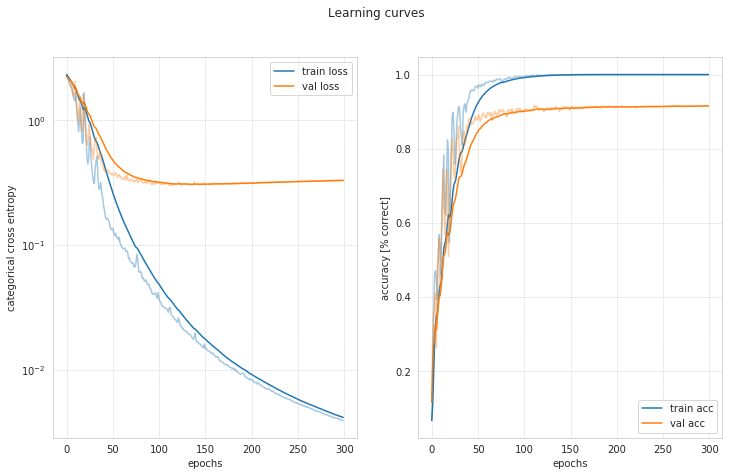

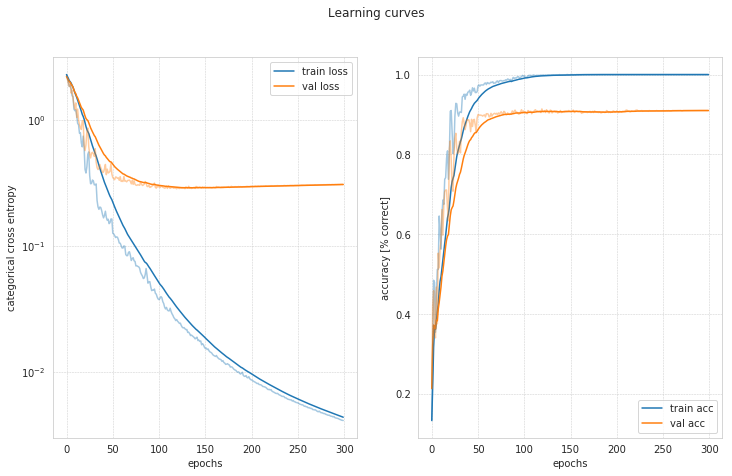

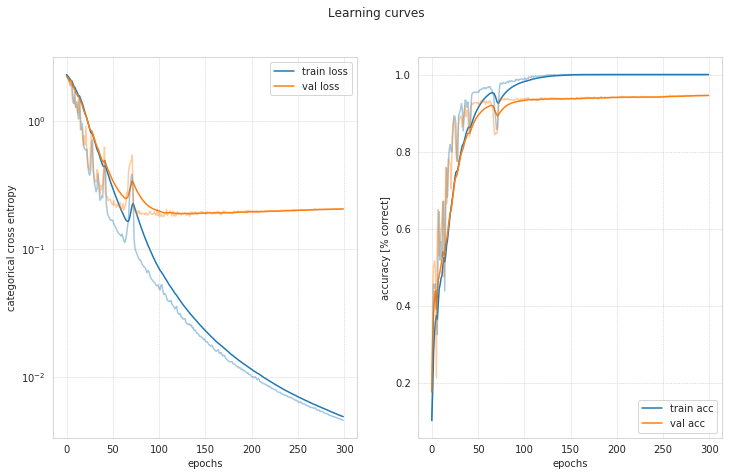

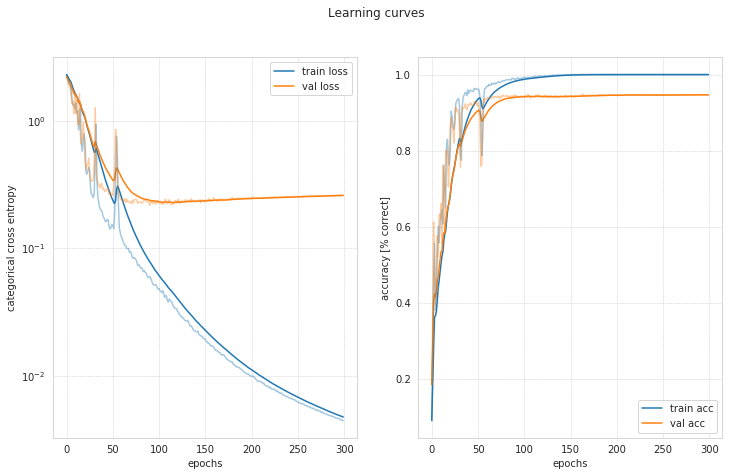

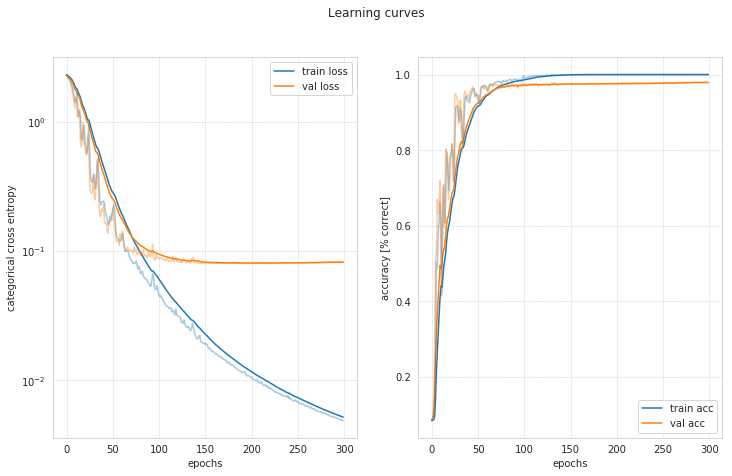

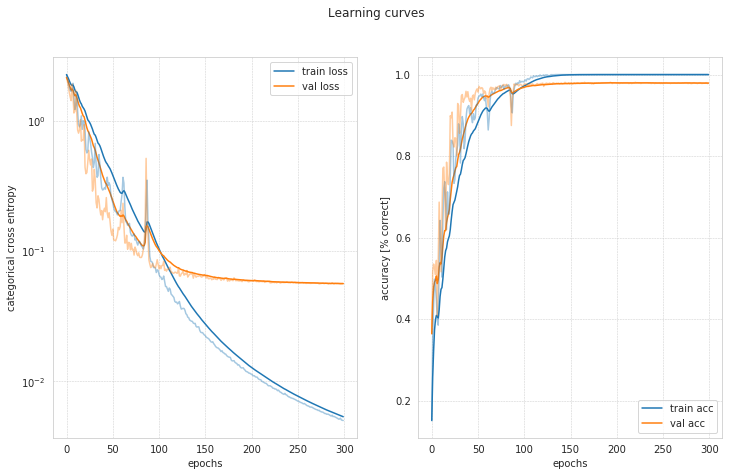

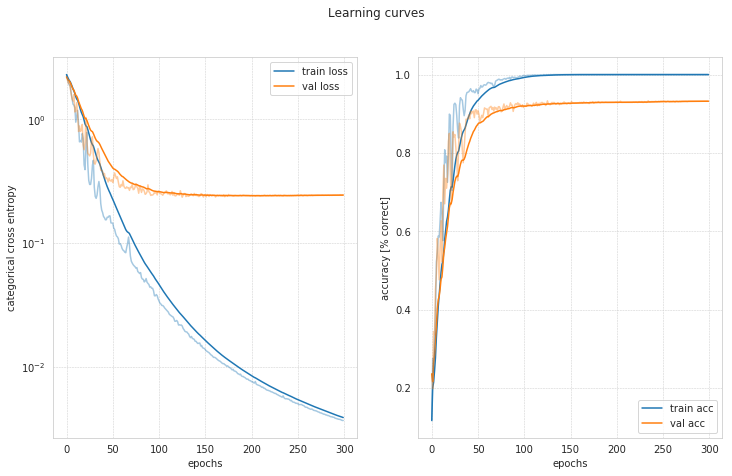

In [181]:
shadow_models = list()
nb_shadow_models = 10

(shadow_train_datasets, shadow_test_datasets) = \
    generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)

for i in range(nb_shadow_models):
    print("training model", i)
    shadow_models.append(LeoNet())
    
    crit_fun = lambda input_, target : (input_, target)
    y_hat_fun = lambda y: y.argmax(1)

    loss_fun = nn.CrossEntropyLoss()
    learning_rate = 0.1
    
    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=300, batch_size=500, verbose=100)
    mt.plot_training("Learning curves")

In [243]:
if not load_from_memory:
    save_model_state(model, 'model_F.pickle')

In [244]:
if load_from_memory:
    load_model_state(model, 'model_F.pickle')

## 2) Differentiate layer activation from training sample than one from a testing sample (per classes)

In [15]:
model.eval()

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [16]:
model.fc1

Linear(in_features=576, out_features=32, bias=True)

In [17]:
layer = model.fc1
layer_name = "model.fc1"

In [33]:
g_train_dataset, g_test_dataset = \
generate_dataset_g_per_class(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7) 

In [43]:
g_train_dataset[1][0].shape

torch.Size([75, 1, 32])

In [45]:
choosen_class = 1
g_train_dataset = g_train_dataset[choosen_class]
g_test_dataset = g_test_dataset[choosen_class]

In [46]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 1
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
    model = nn.Sequential(
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        #nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        #nn.ReLU(),
        #nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        #nn.Linear(64, 128),
        #nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),  
    )
    return model


In [47]:
size_input_vector = g_train_dataset[0].shape
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([75, 1, 32])


In [48]:
g_target_weigths = torch.abs(1-computeClassesWeights(g_train_dataset[1]))
g_target_weigths

tensor([0.4800, 0.5200])

In [138]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 32),
        nn.ELU(),
        nn.BatchNorm1d(32),

        nn.Linear(32, 32),
        nn.ELU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 8),
        nn.ELU(),
        nn.BatchNorm1d(8),
        
        nn.Linear(8, 2)
    )
    return model

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.71861970           0.560      0.71145892           0.471
25                   0.51738463           0.733      0.75210869           0.441
50                   0.49226847           0.787      0.76045310           0.588
75                   0.42638547           0.867      1.12059200           0.412
100                  0.36734951           0.827      1.13735259           0.235
125                  0.34465018           0.827      1.13362539           0.529
150                  0.35862907           0.853      1.27916431           0.471
175                  0.23430428           0.893      1.41240573           0.441
200                  0.33143208           0.867      1.46363926           0.471
225                  0.20194526           0.933      1.35313785           0.500
250                  0.35509425         

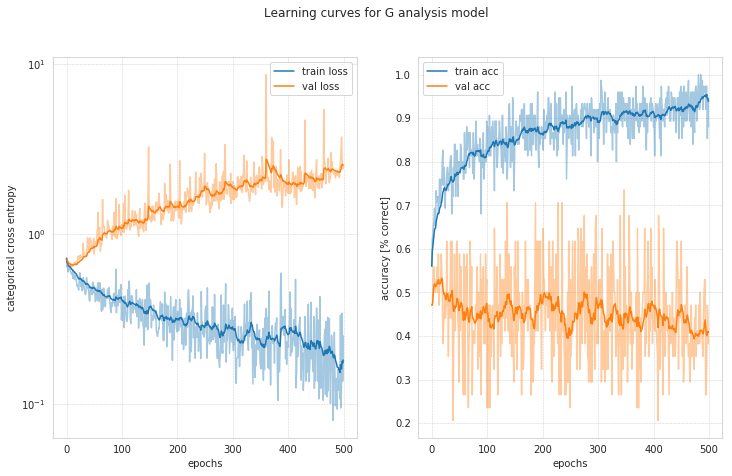

In [139]:
modelG = denseG(32)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()#g_target_weigths)
learning_rate = 0.01
epochs = 500

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=epochs, batch_size=10, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [132]:
modelG.eval()
pass

In [133]:
positive_train = modelG(g_train_dataset[0][g_train_dataset[1] == 1]).softmax(1).detach().cpu().numpy()
negative_train = modelG(g_train_dataset[0][g_train_dataset[1] == 0]).softmax(1).detach().cpu().numpy()

positive_test = modelG(g_test_dataset[0][g_test_dataset[1] == 1]).softmax(1).detach().cpu().numpy()
negative_test = modelG(g_test_dataset[0][g_test_dataset[1] == 0]).softmax(1).detach().cpu().numpy()

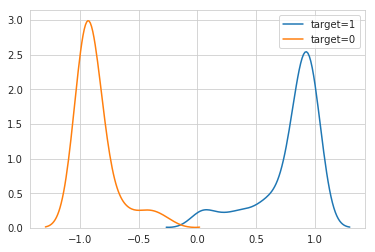

In [134]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_train[:, 1]-positive_train[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_train[:, 1]-negative_train[:, 0], bw=0.1, ax=g, label='target=0')

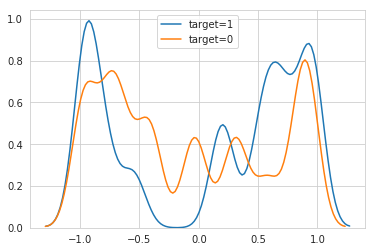

In [135]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_test[:, 1]-positive_test[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_test[:, 1]-negative_test[:, 0], bw=0.1, ax=g, label='target=0')

In [73]:
print("false negative percentage :", 100 - 100*positive_test.argmax(1).sum()/positive_test.shape[0])
print("false positive percentage :", 100*negative_test.argmax(1).sum()/negative_test.shape[0])

false negative percentage : 56.25
false positive percentage : 11.11111111111111


In [63]:
sum(x.numel() for x in modelG.parameters())

7346

## 4) Train 10 shadow F models

In [20]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [22]:
(shadow_train_datasets, shadow_test_datasets) = generate_n_shadow_models_datasets(10, train_dataset, test_dataset)

training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !
training shadow model [5] ...done !
training shadow model [6] ...done !
training shadow model [7] ...done !
training shadow model [8] ...done !
training shadow model [9] ...done !


SyntaxError: 'return' outside function (<ipython-input-26-8b3f6dc78f23>, line 28)

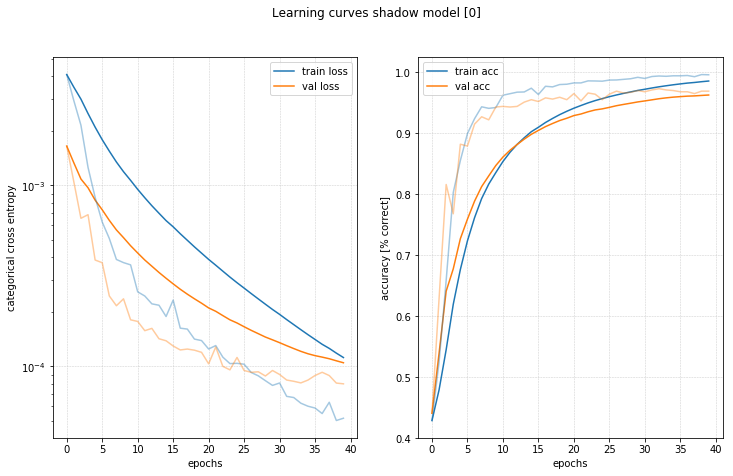

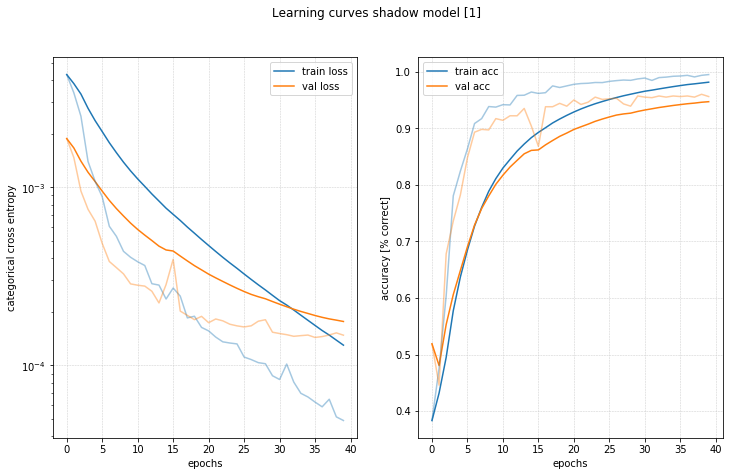

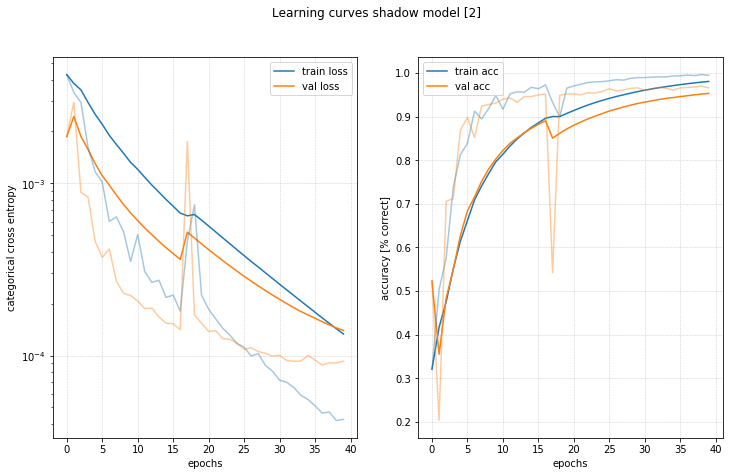

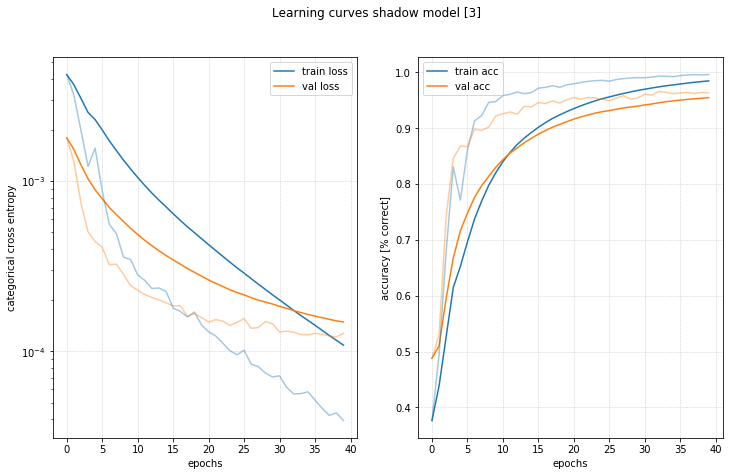

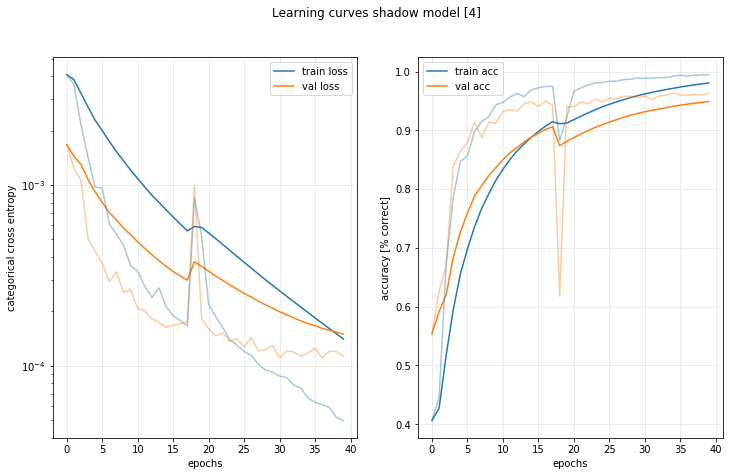

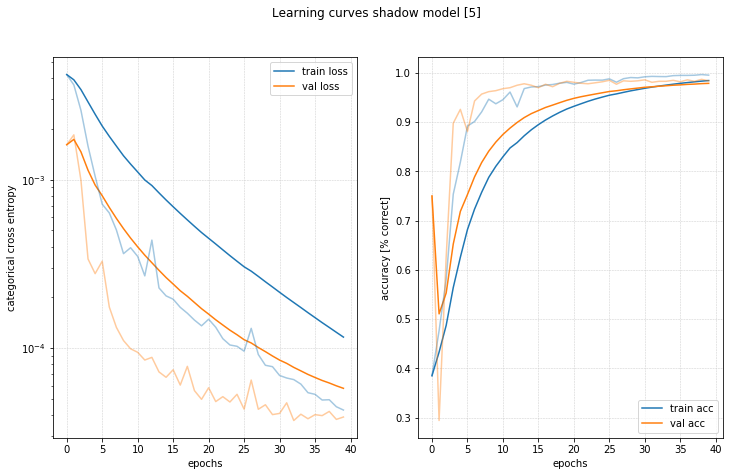

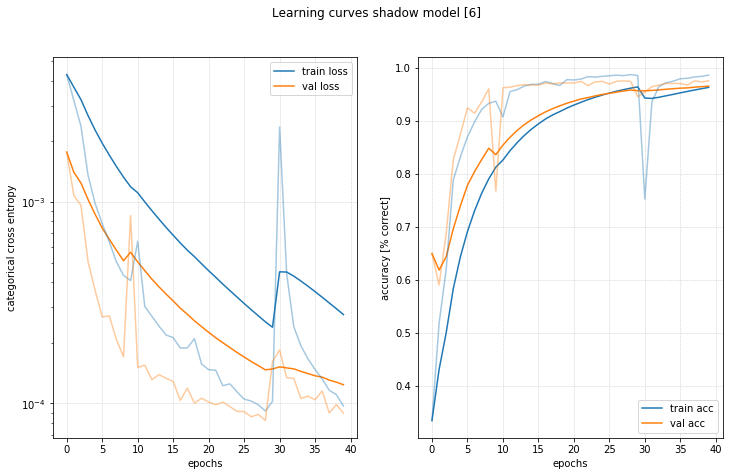

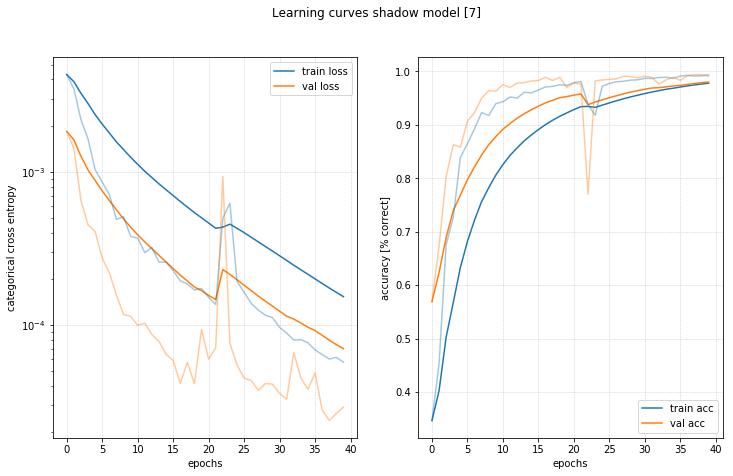

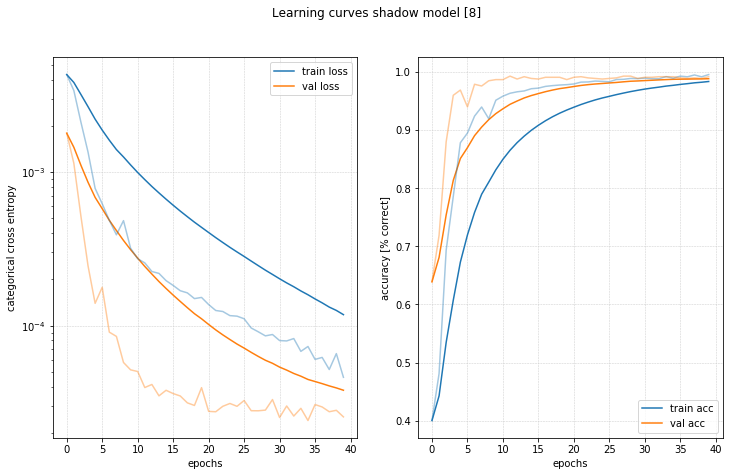

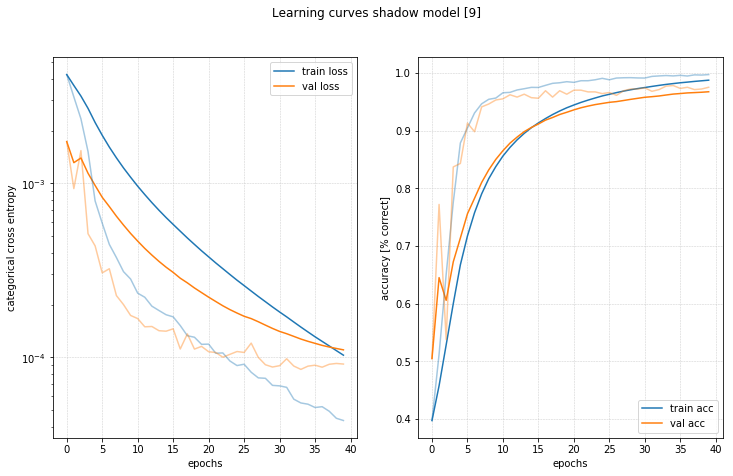

In [26]:
#Define training parameters
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 40
batch_size = 500
verbose = 0

#create the shadow models
model_class = LeNet
shadow_models = list()
for i in range(10):
    shadow_models.append(model_class())
    
#train the shadow models
for i in range(10):
    print("training shadow model ["+str(i)+"] ...", end='')

    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")


In [27]:
for i in range(10):
    shadow_models[i].eval()

## 5) (REPORT TO LATER) Generate shadow G datasets per classes

In [23]:
shadow_layers = list()
shadow_layers_names = list()
for i in range(10):
    shadow_layers.append(models[i].conv2)
    shadow_layers_names.append("shadow model ["+str(i)+"] layer conv2")

In [24]:
split = 0.7

shadow_g_train_input = train_input.new()
shadow_g_train_target = train_target.new()
shadow_g_test_input = test_input.new()
shadow_g_test_target = test_target.new()

for i in range(10):
    (tmp_g_train_input, tmp_g_train_target), (tmp_g_test_input, tmp_g_test_target) = \
    generate_dataset_g(models[i], shadow_train_datasets[i], shadow_test_datasets[i], [shadow_layers[i]], [shadow_layers_names[i]], split=split)
    
    shadow_g_train_input = torch.cat((shadow_g_train_input,tmp_g_train_input))
    shadow_g_train_target = torch.cat((shadow_g_train_target,tmp_g_train_target))
    
    shadow_g_test_input = torch.cat((shadow_g_test_input,tmp_g_test_input))
    shadow_g_test_target = torch.cat((shadow_g_test_target,tmp_g_test_target))
    
shadow_g_train_dataset = (shadow_g_train_input, shadow_g_train_target)
shadow_g_test_dataset = (shadow_g_test_input, shadow_g_test_target)

In [25]:
shadow_g_train_input.shape

torch.Size([14000, 1, 1024])

In [71]:
unique_classes = torch.unique(shadow_g_train_target)

In [78]:
shadow_g_train_input[shadow_g_train_target == 1].shape

torch.Size([7000, 1, 1024])